In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator


In [5]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

In [6]:
data_cali = data.loc[data['region'] == 'California']
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']

In [7]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

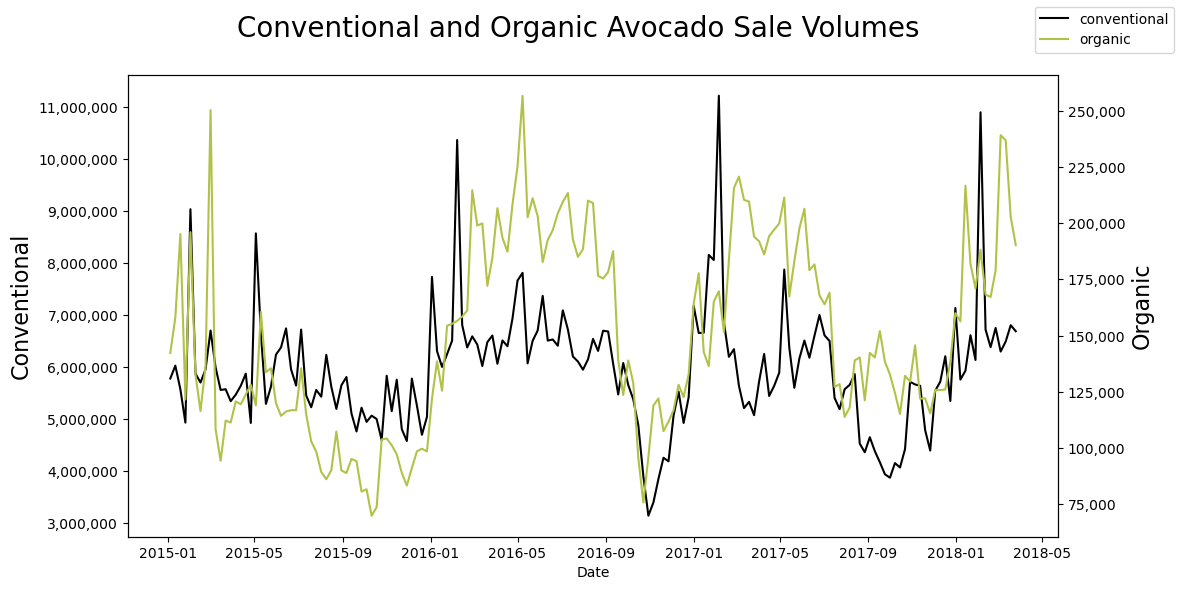

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_con,
    label='conventional',
    ax=ax,
    color='black',
    legend=False
)
plt.ylabel('Conventional',size=16)
ax2 = ax.twinx()
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_org,
    label='organic',
    ax=ax2,
    color='#B2C248',
    legend=False
)
ax.figure.legend()
plt.ylabel('Organic',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Conventional and Organic Avocado Sale Volumes',size=20)
plt.show()

In [9]:
corr = np.corrcoef(data_cali_org['Total Volume'].values,data_cali_con['Total Volume'].values)[0,1]
print('{:.2%}'.format(corr))

48.02%


In [10]:
fcon = Forecaster(
    y=data_cali_con['Total Volume'],
    current_dates = data_cali_con['Date'],
    test_length = .2,
    future_dates = 52,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
fcon

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [11]:
forg = Forecaster(
    y=data_cali_org['Total Volume'],
    current_dates = data_cali_org['Date'],
    test_length = .2,
    future_dates = 52,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
forg

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

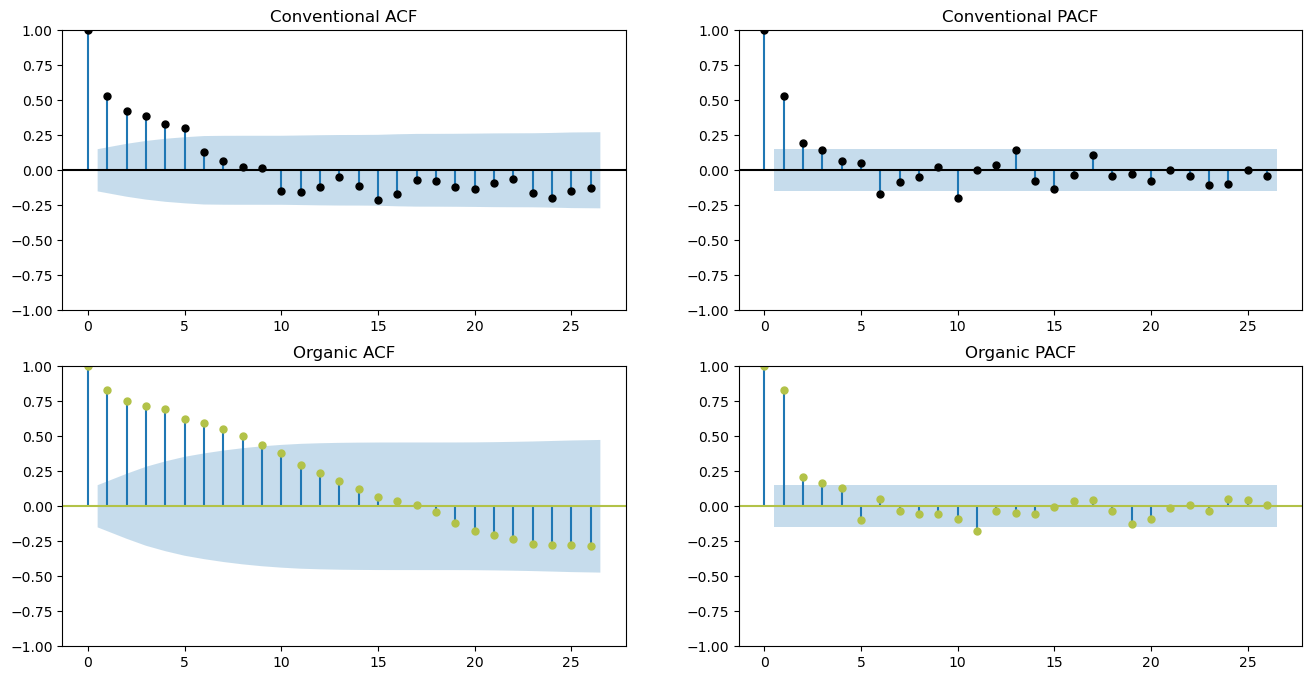

In [12]:
figs, axs = plt.subplots(2, 2,figsize=(16,8))
fcon.plot_acf(
    ax=axs[0,0],
    title='Conventional ACF',
    lags=26,
    color='black'
)
fcon.plot_pacf(
    ax=axs[0,1],
    title='Conventional PACF',
    lags=26,
    color='black',
    method='ywm'
)
forg.plot_acf(
    ax=axs[1,0],
    title='Organic ACF',
    lags=26,
    color='#B2C248'
)
forg.plot_pacf(
    ax=axs[1,1],
    title='Organic PACF',
    lags=26,
    color='#B2C248',
    method='ywm'
)
plt.show()

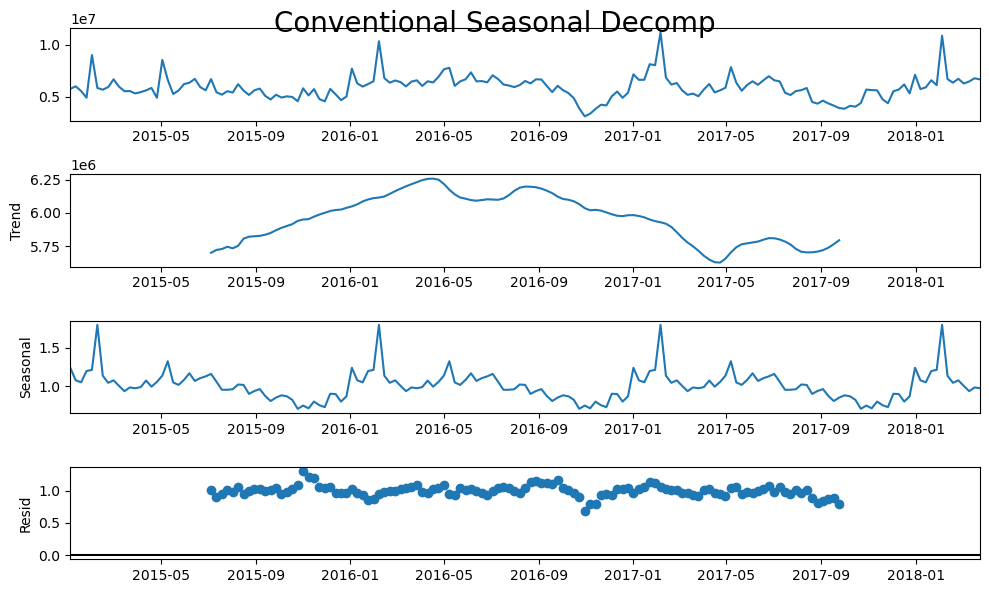

In [13]:
plt.rc("figure",figsize=(10,6))
fcon.seasonal_decompose(model='mul').plot()
plt.suptitle('Conventional Seasonal Decomp',size=20)
plt.show()

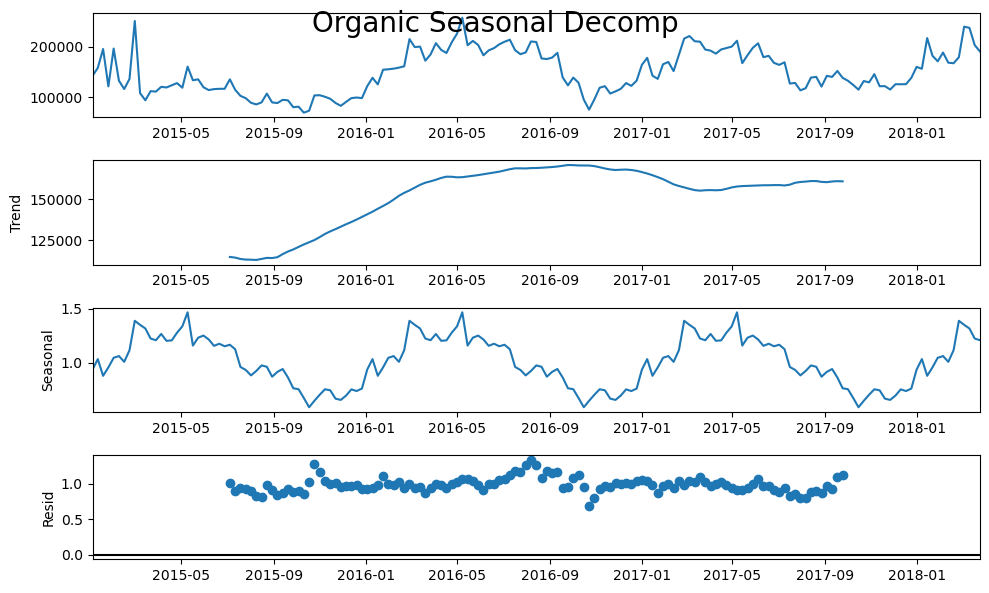

In [14]:
forg.seasonal_decompose(model='mul').plot()
plt.suptitle('Organic Seasonal Decomp',size=20)
plt.show()

In [15]:

critical_pval = 0.05
print('-'*100)
print('Conventional Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fcon.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('Organic Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = forg.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Conventional Augmented Dickey-Fuller results:
the test-stat value is: -3.35
the p-value is 0.0128
the series is stationary
----------------------------------------------------------------------------------------------------
Organic Augmented Dickey-Fuller results:
the test-stat value is: -2.94
the p-value is 0.0404
the series is stationary
----------------------------------------------------------------------------------------------------


In [16]:
for f in (fcon,forg):
    f.auto_Xvar_select(
        estimator = 'elasticnet',
        monitor = 'ValidationMetricValue',
        irr_cycles = [26], # try irregular semi-annual seaosnality
        cross_validate=True,
        cvkwargs={
            'k':3,
            'test_length':13,
            'space_between_sets':4,
        }
    )
    print(f)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33']
    TestLength=33
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)
Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=['lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23',

In [17]:
fcon.tune_test_forecast(models,feature_importance=True)
best_model_con_uni = fcon.order_fcsts()[0]
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

C:\Users\mesut\anaconda3\lib\site-packages\scalecast\_Forecaster_parent.py:1550: Warning: The last CV fold will not be considered when choosing hyperparemeters for the knn model, as all parameters failed to return a metric. This most frequently happens when default CV parameters were used with an RNN model.
  warnings.warn(
C:\Users\mesut\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mesut\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\mesut\anaconda3\lib\site-packages\scalecast\_Forecaster_parent.py:1559: Warning: None of the keyword/value combos stored in the grid could be evaluated for the knn model. See the errors in warnings.log.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

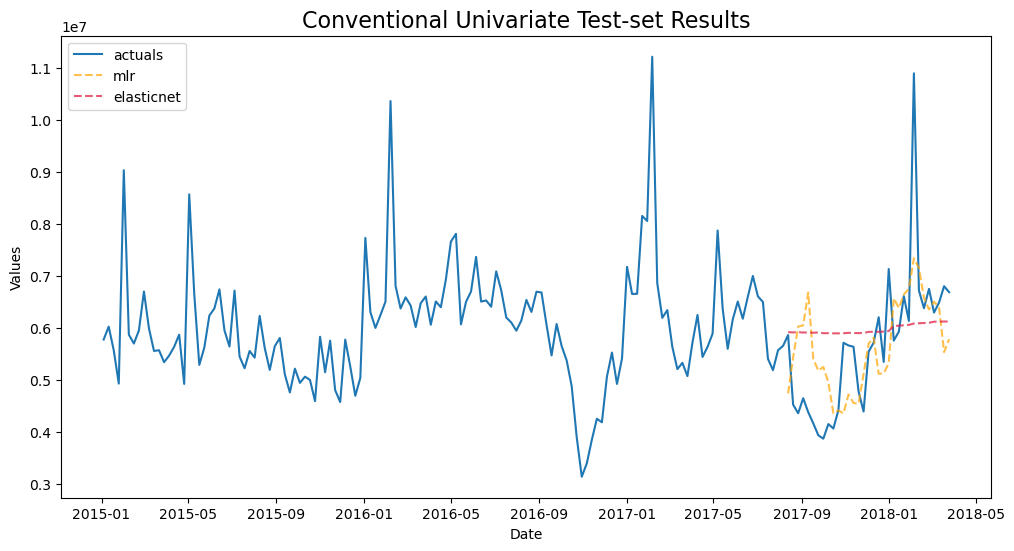

In [18]:
fcon.plot_test_set(order_by='TestSetRMSE')
plt.title('Conventional Univariate Test-set Results',size=16)
plt.show()

In [19]:
forg.tune_test_forecast(models,feature_importance=True)
best_model_org_uni = forg.order_fcsts()[0]
forg.set_estimator('combo')
forg.manual_forecast(how='weighted')

C:\Users\mesut\anaconda3\lib\site-packages\scalecast\_Forecaster_parent.py:1550: Warning: The last CV fold will not be considered when choosing hyperparemeters for the knn model, as all parameters failed to return a metric. This most frequently happens when default CV parameters were used with an RNN model.
  warnings.warn(
C:\Users\mesut\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mesut\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\mesut\anaconda3\lib\site-packages\scalecast\_Forecaster_parent.py:1559: Warning: None of the keyword/value combos stored in the grid could be evaluated for the knn model. See the errors in warnings.log.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

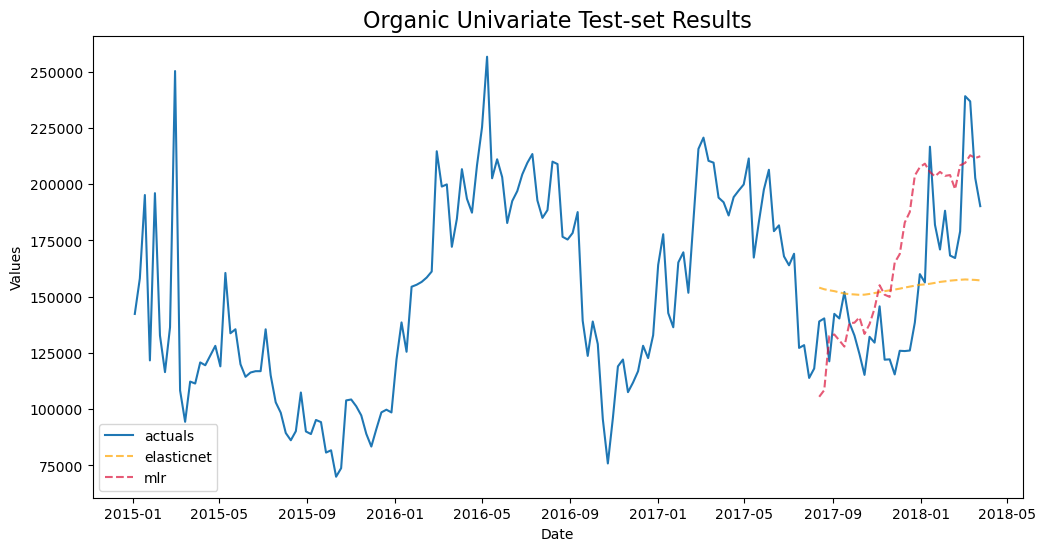

In [20]:
forg.plot_test_set(order_by='TestSetRMSE')
plt.title('Organic Univariate Test-set Results',size=16)
plt.show()